<figure>
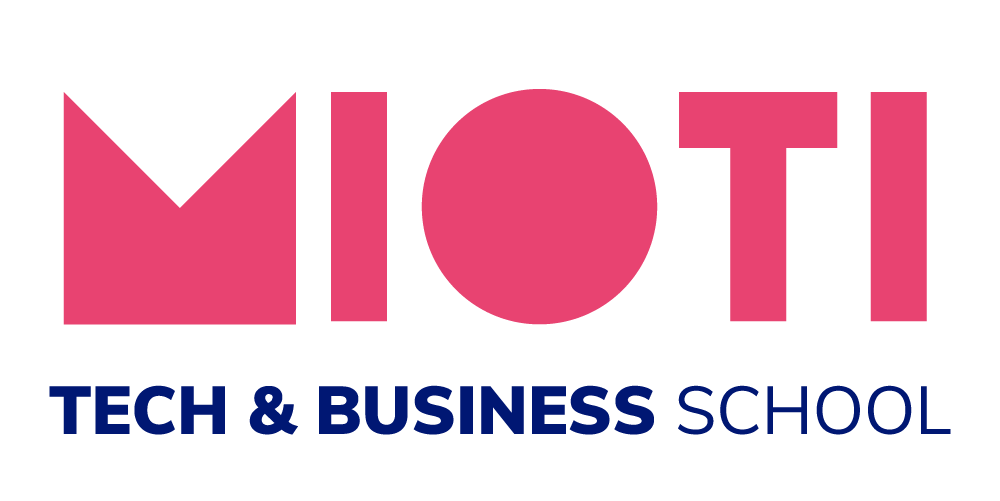
<figcaption></figure>

# Predictive Analytics

### Regression Models Applied to Time Series (scikit-learn)

## Objective

The goal of this challenge is to develop a predictive model using a retail dataframe to forecast sales quantities for a specific item. To achieve this, we will begin by exploring the dataset to gain insights into the behavior of the selected item and identify any unique characteristics it may possess. 

Following this exploratory analysis, we will build a predictive model by experimenting with various models and using hyperparameter tuning. Finally, we will enhance the model's performance by incorporating relevant synthetic variables that can improve its understanding of the sales dynamics for the chosen product.

## 1. Environment Setup

Let's load the libraries that we will use for the challenge.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# optional - suppress warnings
import warnings
warnings.filterwarnings("ignore")

## 2. Data Loading and Preprocessig

Loading our dataframe as *df_retail* and translate the columns to English.

In [5]:
df_retail = pd.read_csv('df_retail.csv', delimiter=',')

df_retail.rename(columns={
    'Fecha': 'Date',
    'Referencia': 'Reference',
    'Unidades': 'Units',
    'Ventas': 'Sales'
}, inplace=True)

df_retail.head(10)

,Date,Reference,Units,Sales
0,2017-01-01,Cerveza tercio,18.000000,11.700000
1,2017-01-01,Baguetes 2 unidades,34.000000,33.320001
2,2017-01-02,Aceite de oliva virgen extra 5 l,53.000000,1184.550020
3,2017-01-02,Bolsa naranjas 2Kg.,1118.000000,1889.420064
4,2017-01-02,Mandarina,1752.468997,3356.279999
5,2017-01-02,Melo OR,399.428999,728.429999
6,2017-01-02,Baguetes 2 unidades,3572.000000,3257.839944
7,2017-01-02,Jamón reserva,48.515000,870.689999
8,2017-01-02,Cerveza tercio,1280.000000,802.150005
9,2017-01-02,Naranja en cajas,831.050001,1470.350000


As we can see, our dataset contains sales information for various products over a period of time, consisting of four columns: *Date*, *Reference*, *Units*, and *Sales*. Here is a detailed description of each column and the type of information they contain:

- Date: date of sale (YYYY-MM-DD)
- Reference: name or description of the product sold (in Spanish)
- Units: quantity sold for each product on the given date (float)
- Sales: total sales amount (floating)

To choose an item to analyze, first we need to check how many different items we have in our *Reference* column and what are their names.

In [6]:
df_retail['Reference'].unique()

array(['Cerveza tercio', 'Baguetes 2 unidades',
       'Aceite de oliva virgen extra 5 l', 'Bolsa naranjas 2Kg.',
       'Mandarina', 'Melo  OR', 'Jamón reserva', 'Naranja en cajas',
       'Pack de plátanos', 'MERLUZA PALANGRE 1 - 2 Kg (1 Caja 10Q.)',
       'Tomate jugoso al peso', 'Filetes de salmón', 'Sepia',
       'Fresa premium 500gr'], dtype=object)

Now we filter our *df_retail* to create a new one only with the chosen item: **Jamón reserva**

In [7]:
df_jamon = df_retail[df_retail['Reference']=='Jamón reserva']
df_jamon.head(5)

,Date,Reference,Units,Sales
7,2017-01-02,Jamón reserva,48.515,870.689999
24,2017-01-03,Jamón reserva,63.325,1136.559994
38,2017-01-04,Jamón reserva,42.230,922.829997
46,2017-01-05,Jamón reserva,58.165,1273.139998
56,2017-01-07,Jamón reserva,71.330,1561.350001


Next step is to preprocess our filtered dataframe and create the time series

In [8]:
df_jamon['Date'] = pd.to_datetime(df_jamon['Date'], format='%Y-%m-%d')
df_jamon=df_jamon.set_index('Date')

In [9]:
# Let's check the range of datas in our dataframe
DateMin = df_jamon.index.min()
print(DateMin)

2017-01-02 00:00:00


In [10]:
DateMax = df_jamon.index.max()
print(DateMax)

2019-05-18 00:00:00


In [11]:
# Reindex the dataframe (df_jamon) to include all dates in the date range
date_range = pd.date_range(start=DateMin, end=DateMax,freq='d')
df_jamon = df_jamon.reindex(date_range)

# Treating the missing values
# Fill missing values in 'Unit' and 'Sales' columns with 0
df_jamon['Units']=df_jamon['Units'].fillna(value=0)
df_jamon['Sales']=df_jamon['Sales'].fillna(value=0)
# Fill missing values in the 'Referencia' column using forward fill method (ffill)
df_jamon['Reference']=df_jamon['Reference'].fillna(method='ffill')

# Reset dataframe index
df_jamon=df_jamon.reset_index()
df_jamon=df_jamon.rename(columns={'index':'Date Format'})

# Create a new column 'OffsetDays' that represents the index of the dataframe
df_jamon['OffsetDays'] = df_jamon.index

Let's examine the time series for *Jamón reserva* to ensure that we have one sales entry for each day within our specified range

In [12]:
df_jamon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 867 entries, 0 to 866
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date Format  867 non-null    datetime64[ns]
 1   Reference    867 non-null    object        
 2   Units        867 non-null    float64       
 3   Sales        867 non-null    float64       
 4   OffsetDays   867 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 34.0+ KB


In [13]:
df_jamon.tail(15)

,Date Format,Reference,Units,Sales,OffsetDays
852,2019-05-04,Jamón reserva,93.200,1698.480005,852
853,2019-05-05,Jamón reserva,0.000,0.000000,853
854,2019-05-06,Jamón reserva,57.605,1152.550004,854
855,2019-05-07,Jamón reserva,87.625,1655.840000,855
856,2019-05-08,Jamón reserva,82.815,1406.530000,856
857,2019-05-09,Jamón reserva,99.660,1737.949991,857
858,2019-05-10,Jamón reserva,142.516,2517.459991,858
859,2019-05-11,Jamón reserva,58.800,1014.130000,859
860,2019-05-12,Jamón reserva,0.000,0.000000,860
861,2019-05-13,Jamón reserva,104.325,1812.629994,861


In [14]:
df_jamon.head(15)

,Date Format,Reference,Units,Sales,OffsetDays
0,2017-01-02,Jamón reserva,48.515,870.689999,0
1,2017-01-03,Jamón reserva,63.325,1136.559994,1
2,2017-01-04,Jamón reserva,42.230,922.829997,2
3,2017-01-05,Jamón reserva,58.165,1273.139998,3
4,2017-01-06,Jamón reserva,0.000,0.000000,4
5,2017-01-07,Jamón reserva,71.330,1561.350001,5
6,2017-01-08,Jamón reserva,0.075,1.640000,6
7,2017-01-09,Jamón reserva,39.155,857.149997,7
8,2017-01-10,Jamón reserva,37.225,814.880001,8
9,2017-01-11,Jamón reserva,34.055,745.500002,9


<Axes: >

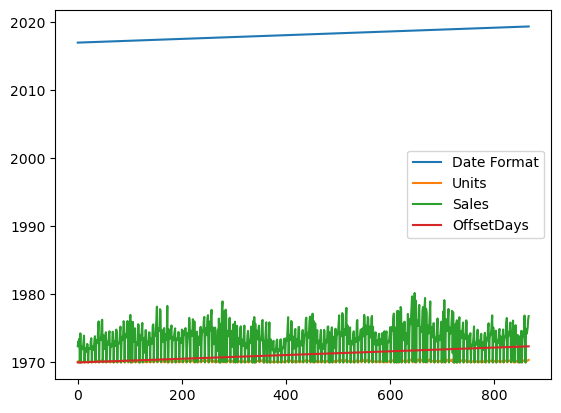

In [15]:
# Now we can plot a graphic to see how our time series looks like 
df_jamon.plot()

## 3. Testing the Prediction with Different Models

To evaluate the effectiveness of various predictive models on our sales database, we will use the evaluation function created below. With this function we can assess the performance of each model, allowing us to identify which approach provides the most accurate forecasts for the number of units sold.

In [16]:
def calculoEvaluacionModelo(modelo,df,norm):

    xPredicted = []
    yPredicted = []
    ySpotted = []
    mean_error = []

    # Using the last two months, we evaluate the chosen model
    for day in range(800,861):
        train = df[df['OffsetDays'] < day]
        val = df[df['OffsetDays'] == day]       
        
        xtr, xts = train.drop(['Date Format','Reference','Units'], axis=1), val.drop(['Date Format','Reference','Units'], axis=1)
        
        if(norm==True):
            sc = StandardScaler()  
            xtr = sc.fit_transform(xtr)  
            xts = sc.transform(xts)  
        ytr, yts = train['Units'].values, val['Units'].values  

        mdl = modelo
        mdl.fit(xtr, ytr)

        p = mdl.predict(xts)

        xPredicted=xPredicted + [day]
        yPredicted=yPredicted + [p[0]]
        ySpotted = ySpotted + [yts[0]]

        error = mean_absolute_error(yts, p)
        print('Day %d - Error %.5f' % (day, error))
        mean_error.append(error)

    print('Mean Error = %.5f' % np.mean(mean_error))
    prediction = pd.DataFrame(
        {'Sold units predicted': yPredicted,
         'Sold units actually spotted': ySpotted
        },index=xPredicted)
    prediction.plot()

### Linear Regression

Day 800 - Error 2.56024
Day 801 - Error 5.10435
Day 802 - Error 7.54597
Day 803 - Error 13.40819
Day 804 - Error 1.42606
Day 805 - Error 7.46336
Day 806 - Error 7.55341
Day 807 - Error 6.27395
Day 808 - Error 1.50846
Day 809 - Error 5.38303
Day 810 - Error 7.34366
Day 811 - Error 1.47429
Day 812 - Error 6.56683
Day 813 - Error 1.35827
Day 814 - Error 3.93697
Day 815 - Error 2.94412
Day 816 - Error 7.06085
Day 817 - Error 0.97372
Day 818 - Error 1.32548
Day 819 - Error 7.29104
Day 820 - Error 5.70910
Day 821 - Error 4.71861
Day 822 - Error 8.94294
Day 823 - Error 6.39859
Day 824 - Error 0.84483
Day 825 - Error 1.42836
Day 826 - Error 1.84578
Day 827 - Error 0.32603
Day 828 - Error 2.86512
Day 829 - Error 1.54662
Day 830 - Error 3.86473
Day 831 - Error 1.93814
Day 832 - Error 1.51756
Day 833 - Error 3.57020
Day 834 - Error 0.68458
Day 835 - Error 0.70007
Day 836 - Error 9.63882
Day 837 - Error 1.62885
Day 838 - Error 3.65792
Day 839 - Error 1.66259
Day 840 - Error 1.63192
Day 841 - Error

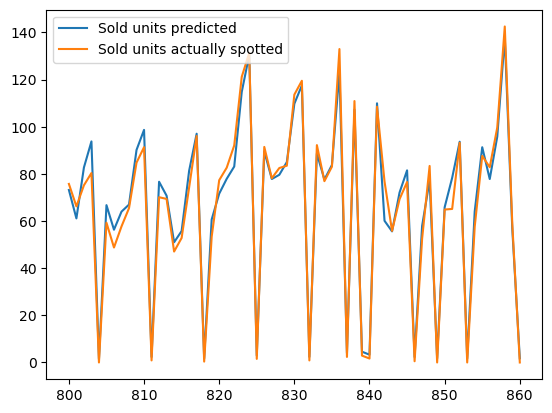

In [17]:
calculoEvaluacionModelo(LinearRegression(),df_jamon,True)

### KNeighbours Regression

Day 800 - Error 3.98500
Day 801 - Error 7.82000
Day 802 - Error 1.91333
Day 803 - Error 15.06167
Day 804 - Error 0.15333
Day 805 - Error 4.13333
Day 806 - Error 3.26833
Day 807 - Error 1.22167
Day 808 - Error 7.60500
Day 809 - Error 3.09333
Day 810 - Error 7.90333
Day 811 - Error 0.72167
Day 812 - Error 8.18667
Day 813 - Error 3.47333
Day 814 - Error 2.08667
Day 815 - Error 2.39500
Day 816 - Error 6.19000
Day 817 - Error 11.56667
Day 818 - Error 0.01667
Day 819 - Error 7.14167
Day 820 - Error 4.34833
Day 821 - Error 6.45333
Day 822 - Error 14.51833
Day 823 - Error 3.86167
Day 824 - Error 5.45667
Day 825 - Error 1.10833
Day 826 - Error 8.27500
Day 827 - Error 0.43500
Day 828 - Error 1.21667
Day 829 - Error 0.00167
Day 830 - Error 4.49633
Day 831 - Error 2.49000
Day 832 - Error 0.05500
Day 833 - Error 9.01500
Day 834 - Error 0.05000
Day 835 - Error 0.50833
Day 836 - Error 5.37200
Day 837 - Error 1.26500
Day 838 - Error 4.29567
Day 839 - Error 1.33167
Day 840 - Error 0.09167
Day 841 - Err

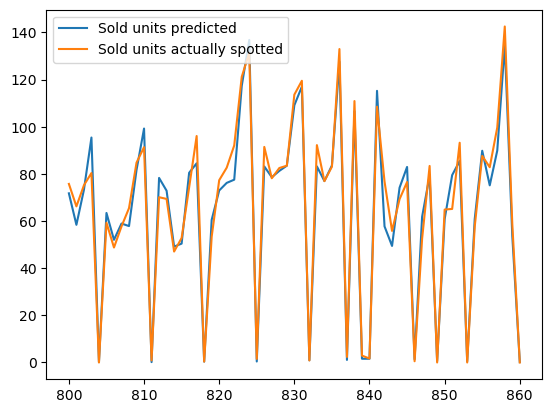

In [18]:
calculoEvaluacionModelo(KNeighborsRegressor(n_neighbors=3),df_jamon,False)

### MLP Regression 

In [ ]:
calculoEvaluacionModelo(MLPRegressor(),df_jamon,False)

Day 800 - Error 7.00236
Day 801 - Error 10.13824
Day 802 - Error 0.33748
Day 803 - Error 7.87276
Day 804 - Error 0.89357
Day 805 - Error 4.05633
Day 806 - Error 4.83632
Day 807 - Error 3.04673
Day 808 - Error 5.62072
Day 809 - Error 0.08874
Day 810 - Error 0.15501
Day 811 - Error 0.61767
Day 812 - Error 1.77076
Day 813 - Error 6.19070
Day 814 - Error 0.19602
Day 815 - Error 2.13828
Day 816 - Error 2.97032
Day 817 - Error 5.58509
Day 818 - Error 0.36244
Day 819 - Error 1.41754
Day 820 - Error 7.31465
Day 821 - Error 11.28295
Day 822 - Error 11.95677
Day 823 - Error 10.71149
Day 824 - Error 0.59194
Day 825 - Error 0.41919
Day 826 - Error 6.96989
Day 827 - Error 3.38146
Day 828 - Error 12.22114
Day 829 - Error 3.50733
Day 830 - Error 7.59070
Day 831 - Error 4.79295
Day 832 - Error 0.36399
Day 833 - Error 8.10146
Day 834 - Error 1.83065
Day 835 - Error 2.15117
Day 836 - Error 10.76751
Day 837 - Error 0.64223
Day 838 - Error 6.91900
Day 839 - Error 1.00190
Day 840 - Error 0.37566
Day 841 - 

### SVR Model

In [ ]:
calculoEvaluacionModelo(SVR(C = 200) ,df_jamon,False)

As we can see, we achieved better results with the **SVR Model**, so we will proceed with this approach, now using the whole dataframe.

In [ ]:
norma=False
df_jamon_simple = df_jamon[['OffsetDays','Reference','Date Format','Units']].copy()
df_jamon_simple.info()


calculoEvaluacionModelo(SVR(C = 200),df_jamon_simple,False)

## 4. Enhancing our Model with Synthetic Variables

Based on your observations of the behavior of the sold units for your Reference, we create now synthetic variables that we believe will help improve the model's predictions.

### Using Lags y Diffs

In [ ]:
df_jamon_simple2 = df_jamon_simple.copy()
df_jamon_simple2['Units_prev'] = df_jamon_simple2['Units'].shift()
df_jamon_simple2['Units_Diff'] = df_jamon_simple2['Units_prev'].diff()
df_jamon_simple2.head()

In [ ]:
df_jamon_simple2 = df_jamon_simple2.dropna()

In [ ]:
calculoEvaluacionModelo(SVR(C = 200),df_jamon_simple2,False)

### Adding week days to the dataframe

In [ ]:
df_jamon_simple2.head()
df_jamon_simple2['Week day'] = df_jamon_simple2['Date Format'].dt.dayofweek

In [ ]:
df_jamon_simple2.head(10)

In [ ]:
df_jamon_simple2['Monday'] =  df_jamon_simple2['Week day'].apply(lambda x: 1 if (x==0) else 0) 
df_jamon_simple2['Tuesday'] =  df_jamon_simple2['Week day'].apply(lambda x: 1 if (x==1) else 0) 
df_jamon_simple2['Wednesday'] =  df_jamon_simple2['Week day'].apply(lambda x: 1 if (x==2) else 0) 
df_jamon_simple2['Thursday'] =  df_jamon_simple2['Week day'].apply(lambda x: 1 if (x==3) else 0) 
df_jamon_simple2['Friday'] =  df_jamon_simple2['Week day'].apply(lambda x: 1 if (x==4) else 0) 
df_jamon_simple2['Saturday'] =  df_jamon_simple2['Week day'].apply(lambda x: 1 if (x==5) else 0) 
df_jamon_simple2['Sunday'] =  df_jamon_simple2['Week day'].apply(lambda x: 1 if (x==6) else 0) 

In [ ]:
df_jamon_lag_days = df_jamon_simple2[['OffsetDays','Date Format', 'Reference','Units','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']].copy()

df_jamon_lag_days['Units_prev1'] = df_jamon_lag_days['Units'].shift(1)
df_jamon_lag_days['Units_prev2'] = df_jamon_lag_days['Units'].shift(2)
df_jamon_lag_days['Units_prev3'] = df_jamon_lag_days['Units'].shift(3)
df_jamon_lag_days['Units_prev4'] = df_jamon_lag_days['Units'].shift(4)
df_jamon_lag_days['Units_prev5'] = df_jamon_lag_days['Units'].shift(5)
df_jamon_lag_days['Units_prev6'] = df_jamon_lag_days['Units'].shift(6)
df_jamon_lag_days['Units_prev7'] = df_jamon_lag_days['Units'].shift(7)

df_jamon_lag_days=df_jamon_lag_days.dropna()
df_jamon_lag_days.head()

In [ ]:
calculoEvaluacionModelo(RandomForestRegressor(n_estimators=20, random_state=0),df_jamon_lag_days,norma)

### Adding months to the dataframe

In [ ]:
df_jamon_simple2['Month'] = df_jamon_simple2['Date Format'].dt.month

In [ ]:
df_jamon_simple2.head()

In [ ]:
df_jamon_simple2['January'] = df_jamon_simple2['Month'].apply(lambda x: 1 if (x == 1) else 0) 
df_jamon_simple2['February'] = df_jamon_simple2['Month'].apply(lambda x: 1 if (x == 2) else 0) 
df_jamon_simple2['March'] = df_jamon_simple2['Month'].apply(lambda x: 1 if (x == 3) else 0) 
df_jamon_simple2['April'] = df_jamon_simple2['Month'].apply(lambda x: 1 if (x == 4) else 0) 
df_jamon_simple2['May'] = df_jamon_simple2['Month'].apply(lambda x: 1 if (x == 5) else 0) 
df_jamon_simple2['June'] = df_jamon_simple2['Month'].apply(lambda x: 1 if (x == 6) else 0) 
df_jamon_simple2['July'] = df_jamon_simple2['Month'].apply(lambda x: 1 if (x == 7) else 0) 
df_jamon_simple2['August'] = df_jamon_simple2['Month'].apply(lambda x: 1 if (x == 8) else 0) 
df_jamon_simple2['September'] = df_jamon_simple2['Month'].apply(lambda x: 1 if (x == 9) else 0) 
df_jamon_simple2['October'] = df_jamon_simple2['Month'].apply(lambda x: 1 if (x == 10) else 0) 
df_jamon_simple2['November'] = df_jamon_simple2['Month'].apply(lambda x: 1 if (x == 11) else 0) 
df_jamon_simple2['December'] = df_jamon_simple2['Month'].apply(lambda x: 1 if (x == 12) else 0)

In [ ]:
df_jamon_lag_days_month = df_jamon_simple2[['OffsetDays','Date Format', 'Reference','Units','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','January','February','March','April','May', 'June', 'July', 'August','September','October','November','December']].copy()

df_jamon_lag_days_month['Units_prev1'] = df_jamon_lag_days_month['Units'].shift(1)
df_jamon_lag_days_month['Units_prev2'] = df_jamon_lag_days_month['Units'].shift(2)
df_jamon_lag_days_month['Units_prev3'] = df_jamon_lag_days_month['Units'].shift(3)
df_jamon_lag_days_month['Units_prev4'] = df_jamon_lag_days_month['Units'].shift(4)
df_jamon_lag_days_month['Units_prev5'] = df_jamon_lag_days_month['Units'].shift(5)
df_jamon_lag_days_month['Units_prev6'] = df_jamon_lag_days_month['Units'].shift(6)
df_jamon_lag_days_month['Units_prev7'] = df_jamon_lag_days_month['Units'].shift(7)

df_jamon_lag_days_month=df_jamon_lag_days_month.dropna()
df_jamon_lag_days_month.head()

In [ ]:
calculoEvaluacionModelo(RandomForestRegressor(n_estimators=20, random_state=0),df_jamon_lag_days_month,norma)

The final mean error achieved was 14,298%. This result indicates the average deviation between the predicted values and the actual sales data. While this error percentage provides insight into the model's performance, there is potential for improvement. Future iterations could involve further tuning of the model parameters, incorporating additional synthetic variables, or exploring alternative modeling techniques to enhance prediction accuracy.